In [2]:
import tensorflow as tf
 
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer, Input, Conv2D, Dense, Flatten, Reshape, Lambda, Dropout
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import pandas as pd
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
import warnings
from PIL import Image
tf.compat.v1.disable_eager_execution()

# Data preparation

In [44]:
batch_size = 32
IMG_HEIGHT=128
IMG_WIDTH = 128
#Load attribute 
dff = pd.read_csv("/kaggle/input/celebaa/list_attr_celeba2.csv")
attr = dff.set_index('image_id')
maindir = "/kaggle/input/celebaa/img_align_celeba/img_align_celeba"

training = tf.keras.preprocessing.image_dataset_from_directory(maindir,image_size = (IMG_HEIGHT, IMG_WIDTH),seed = 12, batch_size = batch_size, labels = None, validation_split = 0.2,
  subset = 'training'
)

# and a validation set generator
validation = tf.keras.preprocessing.image_dataset_from_directory(maindir,image_size = (IMG_HEIGHT, IMG_WIDTH),seed = 12,batch_size =batch_size , labels = None, validation_split = 0.2,
  subset = 'validation'
)
def replicate_inputs_to_outputs(images):
    return images/255, images/255


#trainingdata = training.map(lambda x: x / 255.0) #handle the rescaling without need for the rescale layer
validationdata = validation.map(replicate_inputs_to_outputs)
trainingdata = training.map(replicate_inputs_to_outputs)

Found 19999 files belonging to 1 classes.
Using 16000 files for training.
Found 19999 files belonging to 1 classes.
Using 3999 files for validation.


# Building VAE

In [4]:
#Define sampling layer, 
class Sampling(Layer):        
    def call(self, inputs):
        #get output of variances and means layers, reparametrage
        means, logvar = inputs
        batch = tf.shape(means)[0]
        dim = tf.shape(means)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        samples = means + tf.exp(0.5*logvar)*epsilon
        return samples

# Building the Encoder Part

In [5]:
laten_dim = 256
Imgshape= (128,128,3)

#model filters is 32 32 64 64 and filter size is 3 strides is one 
#Dunctional to accomadate the multi output need 
#def create_encoder():
inpuenc = Input(shape=Imgshape)
#model = rescale_layer = tf.keras.layers.Rescaling(1./255)(inpu)
modelenc = Conv2D(filters=32,kernel_size=3,strides = 2 ,padding="same")(inpuenc)
modelenc = BatchNormalization()(modelenc)
modelenc = LeakyReLU(alpha =0.2)(modelenc)
modelenc = Conv2D(filters=64,kernel_size=3,strides = 2 ,padding="same")(modelenc)
modelenc = BatchNormalization()(modelenc)
modelenc = LeakyReLU(alpha =0.2)(modelenc)
modelenc = Conv2D(filters=128,kernel_size=3,strides = 2,padding="same")(modelenc)
modelenc = BatchNormalization()(modelenc)
modelenc = LeakyReLU(alpha =0.2)(modelenc)
modelenc = Conv2D(filters=256,kernel_size=3,strides = 2,padding="same")(modelenc)
modelenc = BatchNormalization()(modelenc)
modelenc = LeakyReLU(alpha =0.2)(modelenc)

modelenc = Flatten()(modelenc)     
modelenc = Dense(256)(modelenc)
modelenc = LeakyReLU(alpha =0.3)(modelenc)

#dividing the layer and senging layrny variable   
means = Dense(laten_dim)(modelenc)
logvar = Dense(laten_dim)(modelenc)
latents = Sampling()([means, logvar])

encoder = Model(inputs=inpuenc, outputs=[means, logvar,latents]) #encoder is returned

encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Build the Decoder Part

In [7]:
# def create_decoder():
inpudec = Input(shape = (laten_dim,),)
modeldec = Dense(4*4*64, activation='relu')(inpudec)
 
modeldec = Reshape((4,4,64))(modeldec) #idk, idk at amm
modeldec=Conv2DTranspose(filters=256,kernel_size=3, strides=2,padding="same")(modeldec)
modeldec=BatchNormalization()(modeldec)
modeldec=LeakyReLU(alpha =0.3)(modeldec)
modeldec=Conv2DTranspose(filters=128,kernel_size=3, strides=2,padding="same")(modeldec)
modeldec=BatchNormalization()(modeldec)
modeldec=LeakyReLU(alpha =0.3)(modeldec)
modeldec=Conv2DTranspose(filters=64,kernel_size=3, strides=2,padding="same")(modeldec)
modeldec=BatchNormalization()(modeldec)
modeldec=LeakyReLU(alpha =0.3)(modeldec)
modeldec=Conv2DTranspose(filters=32,kernel_size=3, strides=2,padding="same")(modeldec)
modeldec=BatchNormalization()(modeldec)
modeldec=LeakyReLU(alpha =0.3)(modeldec)

modeldec =  Conv2DTranspose(filters=3, kernel_size=(3,3), strides=2, padding='same', activation='sigmoid')(modeldec)
decoder  = Model(inputs=inpudec, outputs = modeldec) #encoder is returned
    
  #  return Model(inputs = inpu, outputs = modeldec )
#decoder = create_decoder()
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              263168    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 256)         147712    
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       2950

# Fit and Train

In [10]:
# COMBINE ENCODER AND DECODER THE COMPLETE THE VARIATIONAL AUTO ENCODER
reconstructions = decoder(latents)

vae = Model([inpuenc], outputs = [reconstructions])
 
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

# Definition of loss function

In [8]:

def vae_kl_loss(y_true, y_pred):
    kl_loss =  - 0.5 * tf.reduce_mean(1 + logvar - tf.square(means) - tf.exp(logvar))
    return kl_loss    

#reconstruction loss
def vae_rc_loss(y_true, y_pred):
    #rc_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    rc_loss = tf.keras.losses.MSE(y_true, y_pred)
    return rc_loss

#total loss
def vae_loss(y_true, y_pred):
    kl_loss = vae_kl_loss(y_true, y_pred)
    rc_loss = vae_rc_loss(y_true, y_pred)
    kl_weight_const = 0.02
    return kl_weight_const*kl_loss + rc_loss

In [9]:

vae.compile(optimizer='adam', loss=vae_loss , metrics=[vae_rc_loss, vae_kl_loss], experimental_run_tf_function=False)

hist = vae.fit(trainingdata,validation_data = validationdata, epochs=50 )

NameError: name 'vae' is not defined

# Load weight of the trained model

vae.save("vae128.h5")

In [11]:
model_path = "/kaggle/input/vazerf/vae128.h5"
vae.load_weights(model_path)
#keep it away from now

2022-12-14 10:28:55.778436: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Reconstruct Samples from dataset

In [25]:
import matplotlib.pyplot as plt

test2_datagen = ImageDataGenerator(rescale=1./255)
test2_generator = test2_datagen.flow_from_directory(
        ('/kaggle/input/celebaa/img_align_celeba/'),
        target_size=(128, 128),
        batch_size=10,
        class_mode=None)


Found 19999 images belonging to 1 classes.


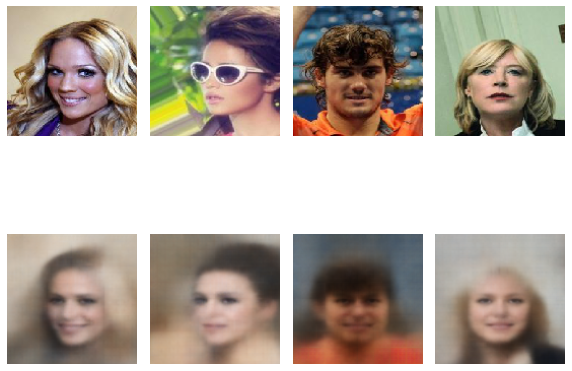

In [25]:
import matplotlib.pyplot as plt
sample_img = next(test2_generator)
 
#we droped the iter 
#enter img
#could make a  function from this to 
z_points = encoder.predict(sample_img)
#reconstructed images
reconst_images = decoder.predict(z_points)
#this

fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

imgnumber =4

for rows in range(imgnumber):
    img = sample_img[rows].squeeze()
    sub = fig.add_subplot(2, imgnumber, rows+1)
    sub.axis('off')        
    sub.imshow(img)

for rows in range(imgnumber):
    img = reconst_images[rows].squeeze()
    sub = fig.add_subplot(2, imgnumber, rows+imgnumber+1)
    sub.axis('off')
    sub.imshow(img)


# Look at the Z distributions

avg_z_mean = []
avg_z_std = []
for i in range(10):
        images = next(test2_generator)    
        z, z_mean, z_logvar = encoder(images)
        avg_z_mean.append(tf.math.reduce_mean(z_mean, axis=0))
        avg_z_std.append(tf.math.reduce_mean(tf.math.exp(0.5*z_logvar),axis=0))

avg_z_mean = tf.math.reduce_mean(avg_z_mean, axis=0)
avg_z_std = tf.math.reduce_mean(avg_z_std, axis=0)


#converting to numpy array with eager execution enabled
plt.plot(avg_z_mean.numpy())
plt.ylabel("Average z mean")
plt.xlabel("z dimension")
plt.plot(avg_z_std)

# Generate Samples

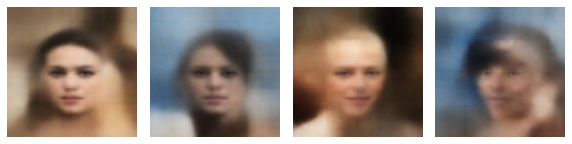

In [41]:
z_dim = 256
z_samples = tf.random.normal( shape=(20, z_dim))
#Newly generated images
images = decoder.predict(z_samples, steps = 2) 
grid_col = 7
grid_row = 2

fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

imgnumber =4

#for i in range(imgnumber):
 #   img = sample_img[i].squeeze()
  #  sub = fig.add_subplot(2, imgnumber, i+1)
   # sub.axis('off')         
    #sub.imshow(img)

for rows in range(imgnumber):
    img = images[rows].squeeze()
    sub = fig.add_subplot(2,imgnumber, rows+imgnumber+1)
    sub.axis('off')
    sub.imshow(img)


# Latent variables exploration

In [92]:
#Plsu de progrès après cette partoe 
#attributes = pd.read_csv("/kaggle/input/celebaa/list_attr_celeba2.csv")
#attributes = pd.DataFrame(dff.iloc[:,:-1].values, columns = dff.columns[1:])
attributes = pd.DataFrame.drop(attributes,columns = ['image_id'])
attributes.head()
attributes.columns



,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [40]:
def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass     

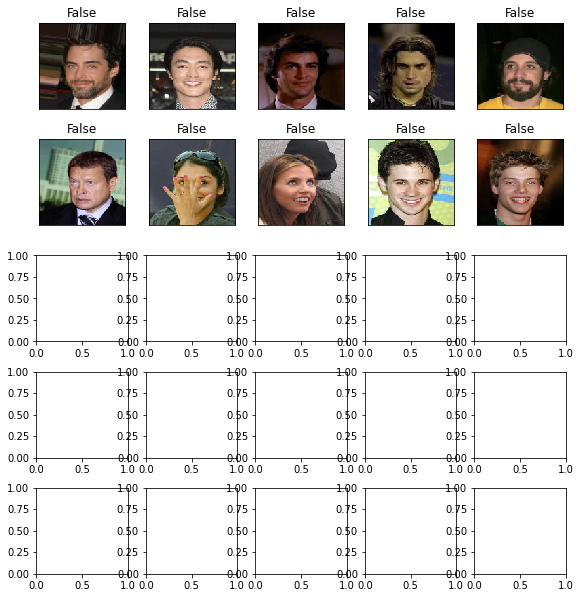

In [69]:

smile_ids = (attributes['Smiling'] == 1 )
smile_data = test2_generator[smile_ids.all()]
#test2_datagen(1)
no_smile_ids = (attributes['Smiling'] == 0)
no_smile_data = test2_generator[no_smile_ids.all()]

eyeglasses_ids = (attributes['Eyeglasses'] == 0)
eyeglasses_data = test2_generator[eyeglasses_ids.all()]


            
plot_gallery(eyeglasses_data,IMG_HEIGHT,IMG_WIDTH,n_row=5,n_col=5,with_title=True,titles=smile_ids)

# Face editing via latent space exploration